# Final Project

## Solutions by: Nick Lewis, Zak Mehdi, Riccardo Gutgeld, Joey Recchia and Jesse Yan

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.regression.rolling import RollingOLS
from itertools import product
import concurrent.futures
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

#################################
# Helper Functions (From HW3)
#################################

def get_sector_tickers(sectors_to_include=None, sectors_to_exclude=None):
    sp500_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    # Replace '.' with '-' to match Yahoo Finance tickers
    sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-')
    sp500_sectors = sp500_df[['Symbol', 'GICS Sector']]

    if sectors_to_include:
        sp500_sectors = sp500_sectors[sp500_sectors['GICS Sector'].isin(sectors_to_include)]
    if sectors_to_exclude:
        sp500_sectors = sp500_sectors[~sp500_sectors['GICS Sector'].isin(sectors_to_exclude)]

    return sp500_sectors.groupby('GICS Sector')['Symbol'].apply(list).to_dict()

def get_highly_correlated_pairs(corr_matrix, threshold=0.9):
    correlated_pairs = []
    tickers = corr_matrix.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            if corr_matrix.iloc[i, j] >= threshold:
                correlated_pairs.append((tickers[i], tickers[j]))
    return correlated_pairs

def find_cointegrated_pairs(data, pairs, significance_level=0.05):
    coint_pairs = []
    pvalues = []
    for pair in tqdm(pairs, desc="Testing Cointegration"):
        s1 = data[pair[0]]
        s2 = data[pair[1]]
        result = ts.coint(s1, s2)
        pvalue = result[1]
        if pvalue < significance_level:
            coint_pairs.append(pair)
            pvalues.append(pvalue)
    return coint_pairs, pvalues

def evaluate_strategy(data, pair, entry, exit, stop_loss, window):
    try:
        S1, S2 = pair
        pair_data = data[[S1, S2]].dropna()
        if len(pair_data) < window:
            return None, None  # Not enough data for rolling window
        Y = pair_data[S1]
        X = sm.add_constant(pair_data[S2])
        rolling_model = RollingOLS(Y, X, window=window)
        rolling_results = rolling_model.fit()
        hedge_ratios = rolling_results.params[S2]
        intercepts = rolling_results.params['const']
        spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        zscore = (spread - spread_mean) / spread_std

        # Define entry/exit logic
        long_entries = (zscore < -entry) & ~(zscore < -stop_loss)  # Long entry, no stop-loss
        short_entries = (zscore > entry) & ~(zscore > stop_loss)  # Short entry, no stop-loss
        long_exit_combined = (zscore > -exit) | (zscore < -stop_loss)  # Long exit or stop-loss
        short_exit_combined = (zscore < exit) | (zscore > stop_loss)  # Short exit or stop-loss

        positions_S1 = pd.Series(0, index=pair_data.index)
        positions_S2 = pd.Series(0, index=pair_data.index)

        
        if long_entries.iloc[0]:
            positions_S1.iloc[0] = 1
            positions_S2.iloc[0] = -hedge_ratios.iloc[0]
        elif short_entries.iloc[0]:
            positions_S1.iloc[0] = -1
            positions_S2.iloc[0] = hedge_ratios.iloc[0]
        else:
            positions_S1.iloc[0] = 0
            positions_S2.iloc[0] = 0

        for t in range(1, len(zscore)):
            previous_position = positions_S1.iloc[t - 1]

            if previous_position == 0:
                # No position is open, check for entries
                if long_entries.iloc[t]:
                    # Open long position
                    positions_S1.iloc[t] = 1
                    positions_S2.iloc[t] = -hedge_ratios.iloc[t]
                elif short_entries.iloc[t]:
                    # Open short position
                    positions_S1.iloc[t] = -1
                    positions_S2.iloc[t] = hedge_ratios.iloc[t]
                else:
                    # Stay flat
                    positions_S1.iloc[t] = 0
                    positions_S2.iloc[t] = 0
            elif previous_position != 0:  # A position is open
                if (previous_position > 0 and long_exit_combined.iloc[t]) or \
                   (previous_position < 0 and short_exit_combined.iloc[t]):
                    # Close position
                    positions_S1.iloc[t] = 0
                    positions_S2.iloc[t] = 0
                else:
                    # Continue holding the current position
                    positions_S1.iloc[t] = previous_position
                    positions_S2.iloc[t] = positions_S2.iloc[t - 1]

        returns_S1 = pair_data[S1].pct_change()
        returns_S2 = pair_data[S2].pct_change()
        strategy_returns = positions_S1.shift(1) * returns_S1 + positions_S2.shift(1) * returns_S2
        strategy_returns.fillna(0, inplace=True)
        
        if strategy_returns.std() == 0:
            return None, None

        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
        return strategy_returns, sharpe_ratio
    except Exception:
        return None, None

def parallel_evaluate(data, pair, entry_thresholds, exit_thresholds, stop_loss_thresholds, rolling_windows):
    best_sharpe = -np.inf
    best_strategy = None
    best_params = None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(evaluate_strategy, data, pair, entry, exit, stop_loss, window):
            (entry, exit, stop_loss, window)
            for entry, exit, stop_loss, window in product(entry_thresholds, exit_thresholds, stop_loss_thresholds, rolling_windows)
            if stop_loss > entry
        }

        for future in concurrent.futures.as_completed(futures):
            entry, exit, stop_loss, window = futures[future]
            try:
                strategy_returns, sharpe = future.result()
                if sharpe is not None and sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_strategy = strategy_returns
                    best_params = (entry, exit, stop_loss, window)
            except Exception:
                pass

    return best_strategy, best_params, best_sharpe

def test_train_split(data, train_duration=4, test_duration=1):
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")
    
    start_year = data.index.min().year
    end_year = data.index.max().year

    train_data_dict = {}
    test_data_dict = {}

    for test_start_year in range(start_year + train_duration, end_year + 1, test_duration):
        train_start = f"{test_start_year - train_duration}-01-01"
        train_end = f"{test_start_year - 1}-12-31"
        test_start = f"{test_start_year}-01-01"
        test_end = f"{test_start_year + test_duration - 1}-12-31"

        train_data = data.loc[train_start:train_end]
        test_data = data.loc[test_start:test_end]

        train_data_dict[test_start_year] = train_data
        test_data_dict[test_start_year] = test_data

    return train_data_dict, test_data_dict

def evaluate_strategy_test(data, pair, entry, exit, stop_loss, window):
    try:
        S1, S2 = pair
        pair_data = data[[S1, S2]].dropna()
        if len(pair_data) < window:
            return None, None, None  # Not enough data for rolling window
        Y = pair_data[S1]
        X = sm.add_constant(pair_data[S2])
        rolling_model = RollingOLS(Y, X, window=window)
        rolling_results = rolling_model.fit()
        hedge_ratios = rolling_results.params[S2]
        intercepts = rolling_results.params['const']
        spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        zscore = (spread - spread_mean) / spread_std

        # Define entry/exit logic
        long_entries = (zscore < -entry) & ~(zscore < -stop_loss)  # Long entry, no stop-loss
        short_entries = (zscore > entry) & ~(zscore > stop_loss)  # Short entry, no stop-loss
        long_exit_combined = (zscore > -exit) | (zscore < -stop_loss)  # Long exit or stop-loss
        short_exit_combined = (zscore < exit) | (zscore > stop_loss)  # Short exit or stop-loss

        positions_S1 = pd.Series(0, index=pair_data.index)
        positions_S2 = pd.Series(0, index=pair_data.index)
        log_entries = []

        # Handle t=0 explicitly
        if long_entries.iloc[0]:
            positions_S1.iloc[0] = 1
            positions_S2.iloc[0] = -hedge_ratios.iloc[0]
            log_entries.append({'Date': positions_S1.index[0], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[0], 'Entry/Exit': 1})
            log_entries.append({'Date': positions_S2.index[0], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[0], 'Entry/Exit': 1})
        elif short_entries.iloc[0]:
            positions_S1.iloc[0] = -1
            positions_S2.iloc[0] = hedge_ratios.iloc[0]
            log_entries.append({'Date': positions_S1.index[0], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[0], 'Entry/Exit': 1})
            log_entries.append({'Date': positions_S2.index[0], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[0], 'Entry/Exit': 1})
        else:
            positions_S1.iloc[0] = 0
            positions_S2.iloc[0] = 0

        # Loop from t=1 to len(zscore)
        for t in range(1, len(zscore)):
            previous_position = positions_S1.iloc[t - 1]

            if previous_position == 0:
                if long_entries.iloc[t]:
                    positions_S1.iloc[t] = 1
                    positions_S2.iloc[t] = -hedge_ratios.iloc[t]
                    log_entries.append({'Date': positions_S1.index[t], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[t], 'Entry/Exit': 1})
                    log_entries.append({'Date': positions_S2.index[t], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[t], 'Entry/Exit': 1})
                elif short_entries.iloc[t]:
                    positions_S1.iloc[t] = -1
                    positions_S2.iloc[t] = hedge_ratios.iloc[t]
                    log_entries.append({'Date': positions_S1.index[t], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[t], 'Entry/Exit': 1})
                    log_entries.append({'Date': positions_S2.index[t], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[t], 'Entry/Exit': 1})
                else:
                    positions_S1.iloc[t] = 0
                    positions_S2.iloc[t] = 0
            elif previous_position != 0:
                if (previous_position > 0 and long_exit_combined.iloc[t]) or \
                   (previous_position < 0 and short_exit_combined.iloc[t]):
                    log_entries.append({'Date': positions_S1.index[t], 'Ticker': S1, 'Pair': pair, 'Volume': previous_position, 'Entry/Exit': -1})
                    log_entries.append({'Date': positions_S2.index[t], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[t - 1], 'Entry/Exit': -1})
                    positions_S1.iloc[t] = 0
                    positions_S2.iloc[t] = 0
                else:
                    positions_S1.iloc[t] = previous_position
                    positions_S2.iloc[t] = positions_S2.iloc[t - 1]

        # Final exit trades
        if positions_S1.iloc[-1] != 0:
            log_entries.append({'Date': positions_S1.index[-1], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[-1], 'Entry/Exit': -1})
        if positions_S2.iloc[-1] != 0:
            log_entries.append({'Date': positions_S2.index[-1], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[-1], 'Entry/Exit': -1})

        # Create trader log DataFrame from log_entries
        trader_log = pd.DataFrame(log_entries)

        # Calculate strategy returns
        returns_S1 = pair_data[S1].pct_change()
        returns_S2 = pair_data[S2].pct_change()
        strategy_returns = positions_S1.shift(1) * returns_S1 + positions_S2.shift(1) * returns_S2
        strategy_returns.fillna(0, inplace=True)

        if strategy_returns.std() == 0:
            return None, None, None

        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
        return strategy_returns, sharpe_ratio, trader_log
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None, None, None

/Users/jesseyan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Benchmark Definition and Data Collection

Energy (XLE) of SP500


In [2]:
BENCHMARK_TICKER = "XLE"
START = "2014-12-31"
END = "2023-12-31"

included_sectors = ["Energy"] 
sector_tickers = get_sector_tickers(sectors_to_include=included_sectors)
# Limit to 10 tickers for faster processing but need to be changed by to entire sector
energy_tickers = sector_tickers.get("Energy", [])

data = pd.DataFrame()
volume = pd.DataFrame()
for ticker in tqdm(energy_tickers, desc="Downloading Energy Tickers"):
    try:
        df = yf.download(ticker, start=START, end=END, progress=False)
        if not df.empty:
            data[ticker] = df['Adj Close']
            volume[ticker] = df['Volume']
    except Exception as e:
        print(f"Could not download {ticker}: {e}")

data.dropna(axis=1, inplace=True)
volume = volume.replace(0, method='ffill')

if data.shape[1] < 2:
    raise ValueError("Not enough tickers with sufficient data.")

data_rets = data.pct_change()
data_rets = data_rets.iloc[1:].copy()

data = data.iloc[1:].copy()
volume = volume.iloc[1:].copy()

dollar_volume = data * volume

In [3]:
train_data_dict, test_data_dict = test_train_split(data, train_duration=4, test_duration=1)
dv_train, dv_test = test_train_split(dollar_volume)
rets_train, rets_test = test_train_split(data_rets)

cointegrated_pairs_dict = {}

for year, ret_train in rets_train.items():
    dv_data = dv_train[year]
    eligible_stocks = dv_data.columns[dv_data.median() >= 1e8]
    filtered_ret_train = ret_train[eligible_stocks]

    if filtered_ret_train.empty:
        print(f"No eligible stocks for year {year} based on dollar volume criteria.")
        continue

    corr_matrix = filtered_ret_train.corr().abs()
    high_corr_pairs = get_highly_correlated_pairs(corr_matrix, threshold=0.75)
    cointegrated_pairs, pvalues = find_cointegrated_pairs(filtered_ret_train, high_corr_pairs, significance_level=0.05)

    coint_df = pd.DataFrame({
        'Pair': cointegrated_pairs,
        'P-Value': pvalues
    }).sort_values('P-Value')

    print(f"\nYear: {year}")
    print("\nTop Cointegrated Pairs:")
    display(coint_df.head())

    if not coint_df.empty:
        cointegrated_pairs_dict[year] = cointegrated_pairs
    else:
        print(f"No cointegrated pairs found for year {year}.")

Testing Cointegration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.23it/s]


Year: 2019

Top Cointegrated Pairs:


,Pair,P-Value
0,"(CVX, XOM)",0.0
1,"(COP, DVN)",0.0
2,"(COP, EOG)",0.0
3,"(COP, HES)",0.0
6,"(HAL, SLB)",0.0


Testing Cointegration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 37.96it/s]


Year: 2020

Top Cointegrated Pairs:


,Pair,P-Value
0,"(COP, HES)",0.000000e+00
3,"(HAL, SLB)",0.000000e+00
2,"(FANG, EOG)",2.507280e-29
1,"(DVN, EOG)",4.611798e-29


Testing Cointegration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 22.85it/s]


Year: 2021

Top Cointegrated Pairs:


,Pair,P-Value
17,"(DVN, HAL)",0.0
30,"(EOG, SLB)",0.0
19,"(DVN, OXY)",0.0
38,"(HES, OXY)",0.0
16,"(DVN, EOG)",0.0


Testing Cointegration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 27.46it/s]


Year: 2022

Top Cointegrated Pairs:


,Pair,P-Value
29,"(DVN, OXY)",0.0
18,"(COP, HES)",0.0
57,"(PSX, SLB)",0.0
25,"(DVN, EOG)",0.0
49,"(HES, OXY)",0.0


Testing Cointegration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 41.54it/s]


Year: 2023

Top Cointegrated Pairs:


,Pair,P-Value
26,"(COP, SLB)",0.0
47,"(XOM, HES)",0.0
43,"(EOG, HES)",0.0
34,"(DVN, SLB)",0.0
33,"(DVN, OKE)",0.0


In [4]:
%%time
entry_thresholds = np.arange(1.5, 2.6, 0.5)
exit_thresholds = np.arange(0.3, 1.1, 0.2)
stop_loss_thresholds = np.arange(1.65, 3.2, 0.5)
rolling_windows = range(10, 31, 5)

# Store results
all_results = {}

for year, train_data in train_data_dict.items():
    cointegrated_pairs = cointegrated_pairs_dict.get(year, [])

    if not cointegrated_pairs:
        print(f"No cointegrated pairs for year {year}. Skipping optimization.")
        continue

    print(f"Optimizing strategies for year {year}...")
    all_strategy_returns = pd.DataFrame()
    best_results = []

    for pair in tqdm(cointegrated_pairs, desc=f"Optimizing Pairs for {year}"):
        best_strategy, best_params, best_sharpe = parallel_evaluate(
            train_data, pair, entry_thresholds, exit_thresholds, stop_loss_thresholds, rolling_windows
        )

        if best_strategy is not None:
            all_strategy_returns[pair] = best_strategy
            best_results.append((pair, *best_params, best_sharpe))

    if not best_results:
        print(f"No successful strategies found for year {year}.")
        continue

    best_results_df = pd.DataFrame(
        best_results,
        columns=['Pair', 'Entry Threshold', 'Exit Threshold', 'Stop-Loss Threshold', 'Rolling Window', 'Sharpe Ratio']
    )
    print(f"\nTop Results for {year}:")
    display(best_results_df.sort_values('Sharpe Ratio', ascending=False))

    portfolio_returns = all_strategy_returns.mean(axis=1)

    all_results[year] = {
        "best_results_df": best_results_df,
        "portfolio_returns": portfolio_returns,
        "strategy_returns": all_strategy_returns
    }

print("Optimization complete.")

Optimizing strategies for year 2019...


Optimizing Pairs for 2019: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:56<00:00, 14.51s/it]


Top Results for 2019:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
0,"(CVX, XOM)",2.0,0.3,3.15,30,1.411634
6,"(HAL, SLB)",1.5,0.9,1.65,10,1.401873
5,"(DVN, HES)",2.5,0.7,3.15,25,1.209005
1,"(COP, DVN)",1.5,0.9,1.65,10,1.110015
7,"(MPC, VLO)",1.5,0.9,2.15,20,0.942855
2,"(COP, EOG)",2.5,0.9,3.15,20,0.681203
3,"(COP, HES)",1.5,0.3,2.15,30,0.548684
4,"(DVN, EOG)",2.5,0.3,2.65,30,0.183673


Optimizing strategies for year 2020...


Optimizing Pairs for 2020: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.31s/it]


Top Results for 2020:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
3,"(HAL, SLB)",1.5,0.3,2.15,15,1.134091
2,"(FANG, EOG)",1.5,0.3,1.65,30,1.006787
0,"(COP, HES)",2.0,0.3,2.15,25,0.964697
1,"(DVN, EOG)",1.5,0.7,1.65,15,0.629481


Optimizing strategies for year 2021...


Optimizing Pairs for 2021: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [10:32<00:00, 14.38s/it]


Top Results for 2021:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
6,"(CVX, KMI)",1.5,0.3,1.65,15,1.559492
33,"(XOM, PSX)",2.5,0.7,3.15,30,1.306671
40,"(KMI, WMB)",1.5,0.5,1.65,10,1.268862
26,"(EOG, XOM)",2.5,0.5,2.65,25,1.258861
32,"(XOM, HES)",1.5,0.9,1.65,20,1.258476
10,"(COP, EOG)",1.5,0.3,3.15,30,1.238929
38,"(HES, OXY)",2.5,0.9,3.15,15,1.226360
4,"(CVX, XOM)",2.0,0.7,2.65,20,1.220469
9,"(COP, FANG)",1.5,0.7,1.65,15,1.135474
8,"(COP, DVN)",1.5,0.3,1.65,20,1.127989


Optimizing strategies for year 2022...


Optimizing Pairs for 2022: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [14:09<00:00, 14.40s/it]


Top Results for 2022:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
36,"(EOG, XOM)",2.5,0.3,3.15,25,1.716150
21,"(COP, OKE)",1.5,0.7,1.65,30,1.598501
10,"(CVX, KMI)",1.5,0.3,1.65,15,1.581265
42,"(XOM, HES)",1.5,0.9,1.65,20,1.497300
16,"(COP, XOM)",1.5,0.9,3.15,10,1.418177
14,"(COP, FANG)",1.5,0.7,2.15,20,1.402311
15,"(COP, EOG)",1.5,0.3,2.15,20,1.387591
31,"(FANG, EOG)",1.5,0.3,2.15,30,1.372233
57,"(PSX, SLB)",2.5,0.5,3.15,20,1.344100
8,"(CVX, XOM)",2.0,0.7,2.15,20,1.289408


Optimizing strategies for year 2023...


Optimizing Pairs for 2023: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [15:18<00:00, 14.34s/it]


Top Results for 2023:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
41,"(EOG, XOM)",2.0,0.3,3.15,25,1.789985
0,"(APA, COP)",2.5,0.9,3.15,25,1.570236
18,"(COP, EOG)",1.5,0.9,2.15,20,1.490445
34,"(DVN, SLB)",1.5,0.7,2.15,30,1.472249
50,"(XOM, SLB)",2.0,0.7,2.15,25,1.439062
...,...,...,...,...,...,...
27,"(DVN, FANG)",1.5,0.3,1.65,30,0.636281
60,"(MPC, VLO)",1.5,0.5,1.65,10,0.592517
6,"(APA, OXY)",2.5,0.3,2.65,20,0.574739
30,"(DVN, HAL)",1.5,0.9,1.65,30,0.536669


Optimization complete.
CPU times: user 1h 23min 14s, sys: 11min 55s, total: 1h 35min 10s
Wall time: 42min 53s


In [5]:
TRADING_COST = 6.5e-4

With the best parameters, we run it on the test data:

In [127]:
test_returns_df = pd.DataFrame(columns=['Date', 'Year', 'Pair', 'Return'])
trade_log = pd.DataFrame(columns=['Date', 'Year', 'Ticker', 'Volume', 'Entry/Exit'])
portfolio_test_returns_df = pd.DataFrame()

for year, results in all_results.items():
    test_data = test_data_dict[year]
    best_results_df = results["best_results_df"]

    best_results_df['Test Sharpe'] = 0
    test_returns = pd.DataFrame()

    valid_pairs = set()  # Track valid pairs with Test Sharpe >= 0

    for index, row in best_results_df.iterrows():
        test_return, test_sharpe, trade_log_year = evaluate_strategy_test(
            test_data,
            row['Pair'],
            row['Entry Threshold'],
            row['Exit Threshold'],
            row['Stop-Loss Threshold'],
            row['Rolling Window']
        )

        if test_return is not None:
            best_results_df.loc[index, 'Test Sharpe'] = test_sharpe

            if test_sharpe >= -999.2:  # Only process pairs with Test Sharpe >= 0
                valid_pairs.add(tuple(row['Pair']))
                test_returns[row['Pair']] = test_return * 100/15 

                pair_returns_df = pd.DataFrame({
                    'Date': test_return.index,
                    'Year': year,
                    'Pair': [row['Pair']] * len(test_return),
                    'Return': test_return.values * 100/15 
                })
                test_returns_df = pd.concat([test_returns_df, pair_returns_df], ignore_index=True)

        if trade_log_year is not None:
            trade_log_year['Year'] = year
            trade_log = pd.concat([trade_log, trade_log_year], ignore_index=True)

    # Filter valid pairs from test_returns
    test_returns = test_returns[[pair for pair in test_returns.columns if pair in valid_pairs]]  

    portfolio_test_returns = test_returns.mean(axis=1) if not test_returns.empty else pd.Series(0, index=test_data.index)

    portfolio_year_df = pd.DataFrame({
        'Date': portfolio_test_returns.index,
        'Year': year,
        'Return': portfolio_test_returns.values
    })
    portfolio_test_returns_df = pd.concat([portfolio_test_returns_df, portfolio_year_df], ignore_index=True)

    cumulative_portfolio_returns = (1 + portfolio_test_returns).cumprod() - 1
    all_results[year]["portfolio_test_returns"] = portfolio_test_returns

    print(f"\nCumulative Portfolio Returns for Year: {year}")
    display(cumulative_portfolio_returns)

print("\nTest Returns DataFrame:")
display(test_returns_df)

portfolio_test_returns_df.set_index('Date', inplace=True)
print("\nPortfolio Test Returns DataFrame:")
display(portfolio_test_returns_df)


Cumulative Portfolio Returns for Year: 2019


Date
2019-01-02    0.000000
2019-01-03    0.000000
2019-01-04    0.000000
2019-01-07    0.000000
2019-01-08    0.000000
                ...   
2019-12-24   -0.374763
2019-12-26   -0.377787
2019-12-27   -0.375920
2019-12-30   -0.372752
2019-12-31   -0.368798
Length: 252, dtype: float64


Cumulative Portfolio Returns for Year: 2020


Date
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-06    0.000000
2020-01-07    0.000000
2020-01-08    0.000000
                ...   
2020-12-24    1.633173
2020-12-28    1.586008
2020-12-29    1.531372
2020-12-30    1.639629
2020-12-31    1.592223
Length: 253, dtype: float64


Cumulative Portfolio Returns for Year: 2021


Date
2021-01-04    0.000000
2021-01-05    0.000000
2021-01-06    0.000000
2021-01-07    0.000000
2021-01-08    0.000000
                ...   
2021-12-27    0.408641
2021-12-28    0.407226
2021-12-29    0.405445
2021-12-30    0.405076
2021-12-31    0.407653
Length: 252, dtype: float64


Cumulative Portfolio Returns for Year: 2022


Date
2022-01-03    0.000000
2022-01-04    0.000000
2022-01-05    0.000000
2022-01-06    0.000000
2022-01-07    0.000000
                ...   
2022-12-23   -0.030336
2022-12-27   -0.022687
2022-12-28   -0.057152
2022-12-29   -0.042734
2022-12-30   -0.050068
Length: 251, dtype: float64


Cumulative Portfolio Returns for Year: 2023


Date
2023-01-03    0.000000
2023-01-04    0.000000
2023-01-05    0.000000
2023-01-06    0.000000
2023-01-09    0.000000
                ...   
2023-12-22    0.130492
2023-12-26    0.125335
2023-12-27    0.123448
2023-12-28    0.128170
2023-12-29    0.131144
Length: 250, dtype: float64


Test Returns DataFrame:


,Date,Year,Pair,Return
0,2019-01-02,2019,"(CVX, XOM)",0.0
1,2019-01-03,2019,"(CVX, XOM)",-0.0
2,2019-01-04,2019,"(CVX, XOM)",0.0
3,2019-01-07,2019,"(CVX, XOM)",0.0
4,2019-01-08,2019,"(CVX, XOM)",0.0
...,...,...,...,...
42415,2023-12-22,2023,"(PSX, VLO)",0.0
42416,2023-12-26,2023,"(PSX, VLO)",0.0
42417,2023-12-27,2023,"(PSX, VLO)",-0.0
42418,2023-12-28,2023,"(PSX, VLO)",-0.0



Portfolio Test Returns DataFrame:


,Year,Return
Date,,
2019-01-02,2019,0.000000
2019-01-03,2019,0.000000
2019-01-04,2019,0.000000
2019-01-07,2019,0.000000
2019-01-08,2019,0.000000
...,...,...
2023-12-22,2023,0.001246
2023-12-26,2023,-0.004561
2023-12-27,2023,-0.001677


Transaction Costs:

In [144]:
test_returns_pivot = test_returns_df.pivot(index='Date', columns='Pair', values='Return')

test_returns_pivot = test_returns_pivot.fillna(0)

test_returns_pivot.columns = [pair for pair in test_returns_pivot.columns]

print("Reformatted Test Returns DataFrame:")
display(test_returns_pivot)

unique_combinations = trade_log[['Pair', 'Date']].drop_duplicates()

for _, row in unique_combinations.iterrows():
    pair = tuple(row['Pair'])  # Get the pair as a tuple
    date = row['Date']

    if pair in test_returns_pivot.columns and date in test_returns_pivot.index:
        test_returns_pivot.at[date, pair] -= TRADING_COST

port_test_rets_post_costs = test_returns_pivot.mean(axis=1)
cum_port_ret_post_costs = (1 + port_test_rets_post_costs).cumprod() - 1
cum_port_ret_post_costs

Reformatted Test Returns DataFrame:


,"(APA, COP)","(APA, DVN)","(APA, EOG)","(APA, FANG)","(APA, HAL)","(APA, HES)","(APA, OXY)","(BKR, HAL)","(BKR, SLB)","(COP, DVN)",...,"(MPC, VLO)","(OKE, WMB)","(PSX, SLB)","(PSX, VLO)","(XOM, HAL)","(XOM, HES)","(XOM, OXY)","(XOM, PSX)","(XOM, SLB)","(XOM, VLO)"
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.095536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-27,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.004111,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


Date
2019-01-02    0.000000
2019-01-03    0.000000
2019-01-04    0.000000
2019-01-07    0.000000
2019-01-08    0.000000
                ...   
2023-12-22    0.350844
2023-12-26    0.345205
2023-12-27    0.343161
2023-12-28    0.348263
2023-12-29    0.351416
Length: 1258, dtype: float64

No Transaction Costs

In [145]:
display(trade_log)
cum_port_ret = (1+portfolio_test_returns_df['Return']).cumprod() - 1
display(cum_port_ret)

,Date,Year,Ticker,Volume,Entry/Exit,Pair,Dollar Volume,Price,Actual Volume
0,2019-04-15,2019,CVX,1.000000,1,"(CVX, XOM)",1.248219e+09,93.365990,267382.0
1,2019-04-15,2019,XOM,-1.185819,1,"(CVX, XOM)",5.212104e+08,61.059547,-143970.0
2,2019-04-30,2019,CVX,1.000000,-1,"(CVX, XOM)",1.999641e+09,93.303825,267382.0
3,2019-04-30,2019,XOM,-1.185819,-1,"(CVX, XOM)",8.339850e+08,60.779430,-143970.0
4,2019-05-09,2019,CVX,-1.000000,1,"(CVX, XOM)",1.553654e+09,94.181984,-329926.0
...,...,...,...,...,...,...,...,...,...
4567,2023-11-07,2023,VLO,0.369725,-1,"(PSX, VLO)",3.133081e+08,118.609924,202404.0
4568,2023-11-30,2023,PSX,-1.000000,1,"(PSX, VLO)",1.141619e+09,124.802544,-182948.0
4569,2023-11-30,2023,VLO,1.762069,1,"(PSX, VLO)",5.433903e+08,121.817261,50630.0
4570,2023-12-04,2023,PSX,-1.000000,-1,"(PSX, VLO)",6.022961e+08,124.366821,-182948.0


Date
2019-01-02    0.000000
2019-01-03    0.000000
2019-01-04    0.000000
2019-01-07    0.000000
2019-01-08    0.000000
                ...   
2023-12-22    1.473411
2023-12-26    1.462129
2023-12-27    1.457999
2023-12-28    1.468329
2023-12-29    1.474838
Name: Return, Length: 1258, dtype: float64

### Actual PnL/Return Calculation

In [160]:
all_results[2023]['best_results_df'].sort_values(by='Test Sharpe', ascending=False).head(20)

,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio,Test Sharpe
17,"(COP, FANG)",1.5,0.9,2.15,25,1.247206,2.102800
34,"(DVN, SLB)",1.5,0.7,2.15,30,1.472249,1.829370
38,"(FANG, HES)",2.0,0.3,2.15,30,1.336223,1.819260
18,"(COP, EOG)",1.5,0.9,2.15,20,1.490445,1.775422
56,"(HES, SLB)",2.5,0.5,2.65,15,1.020477,1.714417
35,"(FANG, EOG)",1.5,0.3,2.65,30,1.174312,1.553373
11,"(CVX, XOM)",2.0,0.3,2.15,30,1.213522,1.487088
49,"(XOM, PSX)",2.5,0.7,3.15,30,1.087939,1.453604
39,"(FANG, OXY)",2.0,0.9,2.15,10,0.874993,1.411750
6,"(APA, OXY)",2.5,0.3,2.65,20,0.574739,1.272597


In [146]:
trade_log['Dollar Volume'] = trade_log.apply(
    lambda row: dollar_volume.loc[row['Date'], row['Ticker']], axis=1
)
trade_log['Price'] = trade_log.apply(
    lambda row: data.loc[row['Date'], row['Ticker']], axis=1
)

In [147]:
# Initialize variables for actual volumes
actual_volumes = {}

# Iterate through rows to calculate Actual Volume
for idx, row in trade_log.iterrows():
    if row['Entry/Exit'] == 1:  # Entry
        # Calculate Real Dollar Volume
        real_dollar_volume = row['Dollar Volume'] / row['Volume']

        # Calculate Actual Volume for the entry
        actual_volume = round((real_dollar_volume * 0.02) / row['Price'])
        trade_log.at[idx, 'Actual Volume'] = actual_volume

        # Store the Actual Volume for the ticker
        actual_volumes[row['Ticker']] = actual_volume

    elif row['Entry/Exit'] == -1:  # Exit
        # Retrieve Actual Volume for the corresponding entry ticker
        trade_log.at[idx, 'Actual Volume'] = actual_volumes.get(row['Ticker'], None)

display(trade_log)
print('Minimum Maximized DV that does not exceed 2% restriction (no slippage):')
min_dv = (trade_log['Price'] * trade_log['Actual Volume']).abs().min()
min_dv

,Date,Year,Ticker,Volume,Entry/Exit,Pair,Dollar Volume,Price,Actual Volume
0,2019-04-15,2019,CVX,1.000000,1,"(CVX, XOM)",1.248219e+09,93.365990,267382.0
1,2019-04-15,2019,XOM,-1.185819,1,"(CVX, XOM)",5.212104e+08,61.059547,-143970.0
2,2019-04-30,2019,CVX,1.000000,-1,"(CVX, XOM)",1.999641e+09,93.303825,267382.0
3,2019-04-30,2019,XOM,-1.185819,-1,"(CVX, XOM)",8.339850e+08,60.779430,-143970.0
4,2019-05-09,2019,CVX,-1.000000,1,"(CVX, XOM)",1.553654e+09,94.181984,-329926.0
...,...,...,...,...,...,...,...,...,...
4567,2023-11-07,2023,VLO,0.369725,-1,"(PSX, VLO)",3.133081e+08,118.609924,202404.0
4568,2023-11-30,2023,PSX,-1.000000,1,"(PSX, VLO)",1.141619e+09,124.802544,-182948.0
4569,2023-11-30,2023,VLO,1.762069,1,"(PSX, VLO)",5.433903e+08,121.817261,50630.0
4570,2023-12-04,2023,PSX,-1.000000,-1,"(PSX, VLO)",6.022961e+08,124.366821,-182948.0


Minimum Maximized DV that does not exceed 2% restriction (no slippage):


226710.14028167725

In [148]:
earliest_test_year = min(test_data_dict.keys())
start_date = f"{earliest_test_year}-01-01"

filtered_data_index = data.index[data.index >= start_date]

pnl_df = pd.DataFrame(index=filtered_data_index, columns=['Current PnL', 'Realized PnL', 'Cumulative PnL', 'Gross Traded Value', 'Transaction Costs'])
pnl_df[:] = 0.0

open_positions = {}
realized_pnl = 0.0

for current_date in filtered_data_index:
    trades_today = trade_log[trade_log['Date'] == current_date]

    gross_traded_value = 0.0

    for _, row in trades_today.iterrows():
        ticker = row['Ticker']
        if row['Entry/Exit'] == 1:
            entry_value = abs(row['Price'] * row['Actual Volume'])
            open_positions[ticker] = {
                'Actual Volume': row['Actual Volume'],
                'Entry Price': row['Price'] * row['Actual Volume']
            }
            gross_traded_value += entry_value
        elif row['Entry/Exit'] == -1:
            if ticker in open_positions:
                entry_value = open_positions[ticker]['Entry Price']
                exit_value = row['Price'] * open_positions[ticker]['Actual Volume']
                realized_pnl += exit_value - entry_value
                del open_positions[ticker]
                gross_traded_value += abs(row['Price'] * row['Actual Volume'])

    current_pnl = 0.0
    for ticker, position in open_positions.items():
        if ticker in data.columns:
            current_price = data.loc[current_date, ticker]
            current_value = current_price * position['Actual Volume']
            current_pnl += current_value - position['Entry Price']

    cumulative_pnl = realized_pnl + current_pnl
    transaction_costs = gross_traded_value * TRADING_COST

    pnl_df.at[current_date, 'Current PnL'] = current_pnl
    pnl_df.at[current_date, 'Realized PnL'] = realized_pnl
    pnl_df.at[current_date, 'Cumulative PnL'] = cumulative_pnl
    pnl_df.at[current_date, 'Gross Traded Value'] = gross_traded_value
    pnl_df.at[current_date, 'Transaction Costs'] = transaction_costs

display(pnl_df)

,Current PnL,Realized PnL,Cumulative PnL,Gross Traded Value,Transaction Costs
Date,,,,,
2019-01-02,0.0,0.0,0.0,0.0,0.0
2019-01-03,0.0,0.0,0.0,0.0,0.0
2019-01-04,0.0,0.0,0.0,0.0,0.0
2019-01-07,0.0,0.0,0.0,0.0,0.0
2019-01-08,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2023-12-22,-73215.428947,12085069.608705,12011854.179757,26921855.00985,17499.205756
2023-12-26,-44899.955055,11983641.844865,11938741.88981,113422283.524315,73724.484291
2023-12-27,-240741.656967,11983641.844865,11742900.187898,0.0,0.0


In [149]:
print("\nEnergy data:")
display(data)


Energy data:


,APA,BKR,CVX,COP,CTRA,DVN,FANG,EOG,EQT,XOM,...,KMI,MPC,OXY,OKE,PSX,SLB,TRGP,TPL,VLO,WMB
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,51.523636,30.595396,73.464256,49.960659,22.583834,42.942337,47.658855,69.802414,39.211098,60.042522,...,25.570723,33.445644,59.455559,26.526808,50.135403,64.894859,64.310730,34.902599,33.860779,25.322721
2015-01-05,48.359409,30.045263,70.527748,47.582962,21.345848,41.350304,45.551468,65.594879,37.117008,58.399647,...,24.877836,32.514973,57.251293,25.007040,47.104656,63.137455,59.583218,34.544708,32.468407,24.320343
2015-01-06,47.834724,29.952663,70.495140,45.618450,21.045725,40.505001,45.623043,63.725742,36.692120,58.089191,...,24.388048,32.193821,56.764729,23.965530,45.786968,61.902744,57.733082,32.769997,32.071541,23.989944
2015-01-07,47.301968,30.758810,70.436401,45.922924,21.225798,40.695190,46.322842,63.324650,36.742699,58.677788,...,24.710598,32.460239,56.772099,23.790169,45.988075,61.895176,57.186443,34.015247,31.822674,23.861145
2015-01-08,49.134315,31.063837,72.048218,47.068275,21.653469,42.139278,48.581322,65.746246,38.214642,59.654469,...,25.289980,33.223007,57.273403,24.050552,47.777393,62.645096,58.802311,36.174480,33.645531,24.090750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,34.765991,33.260311,144.811356,114.454575,24.956051,44.542431,149.722733,118.806534,38.301811,98.548370,...,16.738630,147.857574,60.112381,66.831032,129.808594,51.775692,84.793098,527.808960,128.463943,33.924152
2023-12-26,36.051834,33.903687,146.115204,115.777519,25.081894,45.368908,152.221451,120.779045,38.517925,98.770790,...,16.861433,149.043396,60.735153,67.764519,131.415955,52.360947,85.614525,535.227356,129.425964,33.904846
2023-12-27,35.935810,33.620998,145.635849,115.261963,25.004450,45.116104,151.350250,120.749878,38.488457,98.306625,...,16.785866,146.887329,60.339745,67.612114,130.428299,51.726917,85.135353,534.743896,128.094711,33.817963


In [150]:
xle_data = yf.download(BENCHMARK_TICKER, start=START, end=END, progress=False)
xle_data.dropna(inplace=True)

print("\nBenchmark (XLE) Data:")
display(xle_data.head())



Benchmark (XLE) Data:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,79.290001,80.000000,78.690002,79.160004,53.344398,21541900
2015-01-02,78.730003,79.790001,78.379997,79.529999,53.593708,27749100
2015-01-05,78.419998,78.449997,75.849998,76.239998,51.376659,45395200
2015-01-06,76.110001,76.730003,74.589996,75.120003,50.621910,41876600
2015-01-07,76.029999,76.360001,74.779999,75.279999,50.729729,31192400


## 2. Returns Calculation:

In [151]:
energy_returns = data.pct_change().dropna()

strategy_returns = port_test_rets_post_costs # portfolio_test_returns_df['Return'].astype(float) # pd.concat([portfolio_returns, portfolio_test_returns], axis=0).astype(float) # portfolio_returns #it_returns.mean(axis=1)

xle_data['XLE_Returns'] = xle_data['Adj Close'].pct_change()
benchmark_returns = xle_data['XLE_Returns'].dropna()

aligned_data = pd.concat([strategy_returns, benchmark_returns], axis=1, join='inner')
aligned_data.columns = ['Strategy_Returns', 'XLE_Returns']
aligned_data.dropna(inplace=True)

print("\nAligned Strategy and Benchmark Returns:")
display(aligned_data.head())


Aligned Strategy and Benchmark Returns:


,Strategy_Returns,XLE_Returns
Date,,
2019-01-02,0.0,0.019704
2019-01-03,0.0,-0.009918
2019-01-04,0.0,0.034024
2019-01-07,0.0,0.014866
2019-01-08,0.0,0.007735


## 3. Attribution Model Selection


In [152]:
X = sm.add_constant(aligned_data['XLE_Returns'])
y = aligned_data['Strategy_Returns']
model = sm.OLS(y, X).fit()

alpha = model.params['const']
beta = model.params['XLE_Returns']
explained_by_benchmark = model.fittedvalues
unexplained_returns = aligned_data['Strategy_Returns'] - explained_by_benchmark

annualized_alpha = unexplained_returns.mean() * 252

print("\nOverall Strategy Attribution:")
print(f"Alpha (Daily): {alpha:.6f}")
print(f"Annualized Alpha: {annualized_alpha:.2%}")
print(f"Beta to Benchmark: {beta:.4f}")
print(f"R-squared: {model.rsquared:.4f}")

# Pair-level attribution
pair_contributions = []
for pair in all_strategy_returns.columns:
    pair_ret = all_strategy_returns[pair].dropna()

    pair_data = pd.concat([pair_ret, aligned_data['XLE_Returns']], axis=1, join='inner')
    pair_data.columns = ['Pair_Returns', 'XLE_Returns']
    pair_data.dropna(inplace=True)

    if pair_data.shape[0] < 30:
        continue

    X_pair = sm.add_constant(pair_data['XLE_Returns'])
    y_pair = pair_data['Pair_Returns']
    pair_model = sm.OLS(y_pair, X_pair).fit()

    pair_alpha = pair_model.params['const']
    pair_alpha_annualized = pair_alpha * 252
    pair_beta = pair_model.params['XLE_Returns']

    pair_contributions.append({
        'Pair': pair,
        'Pair Alpha (Daily)': pair_alpha,
        'Pair Alpha (Annualized)': pair_alpha_annualized,
        'Pair Beta to Benchmark': pair_beta,
        'Pair R-squared': pair_model.rsquared
    })

pair_contrib_df = pd.DataFrame(pair_contributions)
pair_contrib_df.sort_values('Pair Alpha (Annualized)', ascending=False, inplace=True)

print("\nPair-Level Attribution:")
display(pair_contrib_df)


pair_contrib_df['Contribution_to_Total_Alpha_%'] = (pair_contrib_df['Pair Alpha (Annualized)'] / annualized_alpha) * 100
print("\nPair Contribution to Total Alpha:")
display(pair_contrib_df[['Pair', 'Pair Alpha (Annualized)', 'Contribution_to_Total_Alpha_%']])



Overall Strategy Attribution:
Alpha (Daily): 0.000248
Annualized Alpha: 0.00%
Beta to Benchmark: 0.0322
R-squared: 0.0084

Pair-Level Attribution:


,Pair,Pair Alpha (Daily),Pair Alpha (Annualized),Pair Beta to Benchmark,Pair R-squared
61,"(OKE, WMB)",0.003655,0.921068,0.064607,0.000961
13,"(CVX, KMI)",0.001993,0.502338,0.078305,0.003603
34,"(DVN, SLB)",0.001543,0.388843,-0.045946,0.004912
45,"(EOG, SLB)",0.001521,0.383195,0.077508,0.008028
22,"(COP, KMI)",0.001453,0.366082,0.069462,0.005266
...,...,...,...,...,...
51,"(XOM, VLO)",0.000218,0.055040,0.017107,0.011084
19,"(COP, XOM)",0.000196,0.049469,-0.001581,0.000248
5,"(APA, HES)",0.000186,0.046941,0.005639,0.000402
6,"(APA, OXY)",0.000169,0.042473,0.013513,0.004433



Pair Contribution to Total Alpha:


,Pair,Pair Alpha (Annualized),Contribution_to_Total_Alpha_%
61,"(OKE, WMB)",0.921068,inf
13,"(CVX, KMI)",0.502338,inf
34,"(DVN, SLB)",0.388843,inf
45,"(EOG, SLB)",0.383195,inf
22,"(COP, KMI)",0.366082,inf
...,...,...,...
51,"(XOM, VLO)",0.055040,inf
19,"(COP, XOM)",0.049469,inf
5,"(APA, HES)",0.046941,inf
6,"(APA, OXY)",0.042473,inf


*Note: the pair alpha can be interpreted as the selection effect from the Brinson-Fachler model*

The extremely small R-squared values at the pair level indicate that the pair returns are not well-explained by the benchmark. This can be expected in a mean-reverting pairs trading strategy since the primary driver of returns is the reversion of the spread, not the market direction.

The total alpha at the portfolio level is effectively zero - to be investigated.

## 4. Attribution Analysis

In our strategy, since we are already within one sector and pursuing a market-neutral strategy, we can think of the allocation effect as the portion of returns explained by the benchmark. Similarly, we can think of the selection effect as the alpha and residual returns from the pairs themselves, beyond what the benchmark explains.
In our single-sector, single-factor case, there’s effectively no multi-segment interaction. Any residual interaction is rolled into the unexplained portion. 

In [153]:
alpha = model.params['const']
beta = model.params['XLE_Returns']

strategy_daily = aligned_data['Strategy_Returns']
benchmark_daily = aligned_data['XLE_Returns']

allocation_component = beta * benchmark_daily

alpha_component = pd.Series(alpha, index=strategy_daily.index)
residual_component = strategy_daily - (alpha_component + allocation_component)

annual_allocation = allocation_component.mean() * 252
annual_alpha_component = alpha_component.mean() * 252
annual_residual = residual_component.mean() * 252

print(f"Annualized Allocation Effect (Explained by Benchmark): {annual_allocation:.4%}")
print(f"Annualized Selection Effect (Alpha + Residual): {(annual_alpha_component + annual_residual):.4%}")

cumulative_strategy = (1 + strategy_daily).cumprod() - 1
cumulative_allocation = (1 + allocation_component).cumprod() - 1
cumulative_alpha_residual = (1 + alpha_component + residual_component).cumprod() - 1

print("\nCumulative Returns (Over Entire Test Period):")
print(f"Cumulative Strategy Returns: {cumulative_strategy.iloc[-1]:.4%}")
print(f"Cumulative Allocation (Benchmark Explained) Returns: {cumulative_allocation.iloc[-1]:.4%}")
print(f"Cumulative Selection (Alpha+Residual) Returns: {cumulative_alpha_residual.iloc[-1]:.4%}")

Annualized Allocation Effect (Explained by Benchmark): 0.6245%
Annualized Selection Effect (Alpha + Residual): 6.2374%

Cumulative Returns (Over Entire Test Period):
Cumulative Strategy Returns: 35.1416%
Cumulative Allocation (Benchmark Explained) Returns: 3.1313%
Cumulative Selection (Alpha+Residual) Returns: 31.0434%


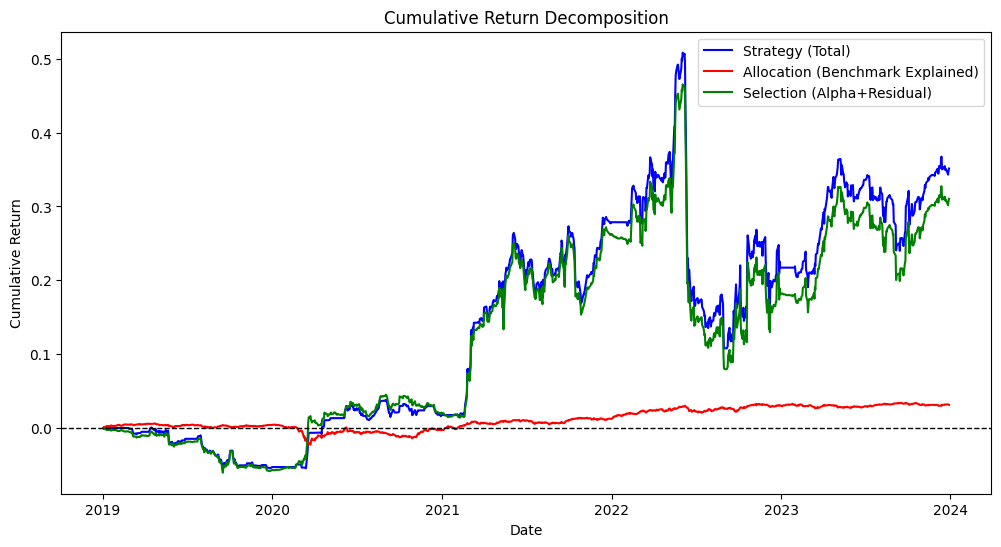

In [154]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumulative_strategy.index, cumulative_strategy, label='Strategy (Total)', color='blue')
ax.plot(cumulative_allocation.index, cumulative_allocation, label='Allocation (Benchmark Explained)', color='red')
ax.plot(cumulative_alpha_residual.index, cumulative_alpha_residual, label='Selection (Alpha+Residual)', color='green')
ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
# ax.axvline(x=test_train_split_line, color='orange', linewidth=1, linestyle='--', label='Test-Train Split')
ax.set_title('Cumulative Return Decomposition')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()

plt.show()

The strategy’s returns are overwhelmingly dominated by selection effects (idiosyncratic stock-pair trades) rather than general market moves (benchmark).

The bulk of our strategy’s returns are coming from alpha (idiosyncratic gains not explained by the benchmark) and residuals (likely the mean-reversion profits you earn from our pairs trades).

## 5. Insight Utilization and Communication

The analysis shows that the selection effect, modeled by alpha and residual effects, dominates the share of returns. In other words, our pair selection methodology to identifying cointegrated pairs, and timing of entries/exits is adding significant value beyond simple exposure to the IT sector via the benchmark. 

Given that the allocation (benchmark-driven) effect was negligible, the strategy is effectively market-neutral and does not rely heavily on the direction of the specific sector or the broader equity market. This is a positive sign since our goal is to produce returns uncorrelated with standard market movements. However, it also means performance is entirely contingent on the successful exploitation of pair relationships. 

However, realistically, we will need to consider transaction costs and slippage. Trading costs may then reduce some of the realized alpha, and could provide a more conservative estimate of returns. Also, cointegration relationships and spread dynamics may change over time, so a periodic re-calibration of pairs and parameters may be necessary. Finally, high selection-driven returns often come from a small set of pairs. Ensuring diversification across multiple pairs and having robust stop-loss mechanisms can help us mitigate idiosyncratic risk.

As a potential adjustment to the strategy, we could consider introducing other common equity risk factors such as size, value, or momentum to understand if our alpha is purely idiosyncratic or if it can be decomposed further into known factor exposures.

In [72]:
aligned_data

,Strategy_Returns,XLE_Returns
Date,,
2019-01-02,0.000000,0.019704
2019-01-03,0.000000,-0.009918
2019-01-04,0.000000,0.034024
2019-01-07,0.000000,0.014866
2019-01-08,0.000000,0.007735
...,...,...
2023-12-22,0.000162,0.002951
2023-12-26,-0.000751,0.008590
2023-12-27,-0.000401,-0.004433


In [73]:
from datetime import datetime
import holoviews as hv
import hvplot.pandas
hv.extension('bokeh')
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    def sortino_ratio(column):
        negative_returns = return_data[column][return_data[column] < 0]
        downside_std = np.sqrt((negative_returns ** 2).mean()) * np.sqrt(annualization)
        return summary_stats.loc[column, 'Mean'] / downside_std if downside_std != 0 else np.nan

    # Apply the sortino_ratio function to each column in return_data
    summary_stats['Sortino Ratio'] = return_data.apply(lambda col: sortino_ratio(col.name), axis=0)

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

def plot_dashboard(return_data):
    cumulative_returns = (1 + return_data).cumprod() - 1
    plot = cumulative_returns.hvplot.line(y='Strategy_Returns', label='Strategy Returns', color='blue', width=1200, height=400)* \
                cumulative_returns.hvplot.line(y='XLE_Returns', label='Benchmark Returns', color='red')
    plot.opts(title='Strategy vs. Benchmark Returns', xlabel='Date', ylabel='Cumulative Return', active_tools=['box_zoom'])

    summary_stats = performance_summary(return_data, 252)
    summary_table = hv.Table(summary_stats.reset_index()).opts(title='Performance Summary', width=1200)

    dashboard = (plot + summary_table).cols(1)
    
    return dashboard

dash = plot_dashboard(aligned_data)
hv.save(dash, 'final_dashboard.html')

In [74]:
dash

:Layout
   .Overlay.I :Overlay
      .Curve.Strategy_Returns  :Curve   [Date]   (Strategy_Returns)
      .Curve.Benchmark_Returns :Curve   [Date]   (XLE_Returns)
   .Table.I   :Table   [index,Mean,Volatility,Sharpe Ratio,Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery]